In [1]:
import matplotlib.pyplot as plt

import os 
import sys
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl

import h5py
import importlib
import hydra
import omegaconf
from omegaconf import DictConfig

from dataclasses import asdict, dataclass, field, InitVar

base_path = os.getcwd()
sys.path.append(base_path)


from automl.models import VAE
from automl.dataloaders import SequenceDataModule,Sequence_WT_DataModule, Embeddings_WT_DataModule, EmbeddingsDataModule

/home/andrea/anaconda3/envs/automl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 4) making predictions with the trained models

Normally a predict/test app should also be included in the module framework, however, here in the interest of time I just load the trained models from checkpoint so we can evaluate predictions on the different datasets. 

In [12]:
#MDefining model architectures to hold the checkpoints

# supervised models
class Supervised_NN(pl.LightningModule):
        def __init__(self, dataset, encoder, measurement, optimizer, loss_function,)-> None:
            super().__init__()
            self.dataset = dataset
            dataset_params = {
                "sequence_length": self.dataset.sequence_length,
                "alphabet_size": self.dataset.alphabet_size,
            }

            self.encoder = hydra.utils.instantiate(encoder, dataset_params=dataset_params)
            self.measurement = hydra.utils.instantiate(measurement)
            self.loss_function = hydra.utils.instantiate(loss_function)

            self.optimizer_params = optimizer

        def forward(self, batch):
            x,y = batch
            mu, _ = self.encoder(x)
            y_hat = self.measurement(mu)

            return torch.stack((y_hat.view(-1), y), dim=1)


# autoencoder model to inspect the latent space
class VAE_pret(pl.LightningModule):
        def __init__(self,dataset, encoder, decoder, optimizer)-> None:
            super().__init__()

            self.dataset = dataset
            dataset_params = {
                "sequence_length": self.dataset.sequence_length,
                "alphabet_size": self.dataset.alphabet_size
            }

            self.encoder = hydra.utils.instantiate(encoder, dataset_params=dataset_params)
            self.decoder = hydra.utils.instantiate(decoder, dataset_params=dataset_params)
            self.optimizer_params = optimizer

In [13]:
#creat the datamodules for our test cases
input_files_rand = {
    "train":  "Data/data_sets/train_data_rand.csv",
    "val": "Data/data_sets/val_data_rand.csv",
    "test": "Data/data_sets/test_data_rand.csv",
}

input_files_single = {
    "train":  "Data/data_sets/df_train_rand_1MJC.csv",
    "val": "Data/data_sets/df_val_rand_1MJC.csv",
    "test": "Data/data_sets/df_test_rand_1MJC.csv",
}

input_files_emb = {
    "train": "Data/data_sets/train_data_rand_emb.csv",
     "val": "Data/data_sets/val_data_rand_emb.csv",
     "test": "Data/data_sets/test_data_rand_emb.csv",
    "embeddings": "protT5/output/residue_embeddings.h5"
}


input_files_emb_wt = {
                "embeddings": "protT5/output/residue_embeddings.h5",
                "wt_embeddings": "protT5/output/wt_embeddings.h5",
                "train":"Data/data_sets/train_data_rand_emb.csv",
                "val": "Data/data_sets/val_data_rand_emb.csv",
                "test": "Data/data_sets/test_data_rand_emb.csv"
}


DM_seq = SequenceDataModule(datafiles=input_files_rand, params = {"sequence_length":72})
DM_seq_wt = Sequence_WT_DataModule(datafiles=input_files_rand,params = {"sequence_length":72})
DM_vae = SequenceDataModule(datafiles=input_files_rand, params = { "sequence_length":72})
DM_single = SequenceDataModule(datafiles=input_files_single, params = {"sequence_length":72})
DM_emb = EmbeddingsDataModule(datafiles=input_files_emb, params = {"sequence_length":72})
DM_emb_wt = Embeddings_WT_DataModule(datafiles=input_files_emb_wt, params = {"sequence_length":72})

In [14]:
# The checkpoint locations for different models
checkpoint_path = 'checkpoints'

model_names = ['MAVE_single_z1', 'MAVE_single_z10', 'MAVE_single_200_z1', 'VAE_z10', 'VAE_z50',
                'MAVE_all_z1', 'MAVE_all_z10', 'MAVE_all_dz1', 'MAVE_emb', 'MAVE_emb10', 'emb_wt']

#the checkpoint paths
model_paths = {}
for nn in model_names:
    model_paths[nn] = os.path.join(checkpoint_path, nn+'.ckpt')



In [20]:
#loading the models from checkpoints

#the VAE models
VAE_model_z10 = VAE_pret.load_from_checkpoint(
    checkpoint_path = model_paths['VAE_z10'],
    dataset = DM_vae
)

VAE_model_z50 = VAE_pret.load_from_checkpoint(
    checkpoint_path = model_paths['VAE_z50'],
    dataset = DM_vae
)

#get the encoders to extract latent space representation
Encoder_z10 = VAE_model_z10.encoder.eval()
Encoder_z50 = VAE_model_z50.encoder.eval()


#the NN models  
# single protein sets      
NN_model_z1 = Supervised_NN.load_from_checkpoint(
        checkpoint_path = model_paths['MAVE_single_z1'],
        dataset = DM_single
    )

NN_model_z10 = Supervised_NN.load_from_checkpoint(
    checkpoint_path = model_paths['MAVE_single_z10'],
    dataset = DM_single
 )

NN_model_200_z10 = Supervised_NN.load_from_checkpoint(
    checkpoint_path = model_paths['MAVE_single_200_z1'],
    dataset = DM_single
 )

###########################
# These come from GPU and require
#  torch.load with map_location=torch.device('cpu') 

# Using all data 
#NN_all_z1_ = Supervised_NN.load_from_checkpoint(
#    checkpoint_path = model_paths['MAVE_all_z1'],
#    dataset = DM_seq
# )

#NN_all_z10 = Supervised_NN.load_from_checkpoint(
#    checkpoint_path=model_paths['MAVE_all_z10'],
#    dataset = DM_seq
# )

#NN_all_dz = Supervised_NN.load_from_checkpoint(
#    checkpoint_path=model_paths['MAVE_all_dz'],
#    dataset = DM_seq_wt
# )

## Problems loading these due to model configuration mismatches
# 

##########################
# Using embeddings
#NN_all_z1_ = Supervised_NN.load_from_checkpoint(
#    checkpoint_path = model_paths['MAVE_emb'],
#    dataset = DM_emb
# )

#NN_all_z10 = Supervised_NN.load_from_checkpoint(
#    checkpoint_path=model_paths['MAVE_emb10'],
#    dataset = DM_emb
# )

#NN_all_dz = Supervised_NN.load_from_checkpoint(
#    checkpoint_path=model_paths['emb_wt'],
#    dataset = DM_emb_wt
# )


## Now we can predict values with the loaded checkpoints

In [21]:
def get_latent_rep(encoder, loader):
    z_vecs = []
    for batch in loader:
        z,_= encoder(batch[0])
        z.detach()
        z_vecs.append(z)
        #for v in z:
        #    z_vecs.append(v.detach())

    return torch.stack(z_vecs).view(-1, z_vecs[0].shape[-1]) 

In [22]:
DM_single.setup(stage=None)
z_vecs_10 = get_latent_rep( Encoder_z10,  DM_single.test_dataloader() )
z_vecs_10= z_vecs_10.detach().numpy()

z_vecs_50 = get_latent_rep( Encoder_z10,  DM_single.test_dataloader() )
z_vecs_50= z_vecs_50.detach().numpy()

In [64]:
#use the pl Trainer to predict pairs of y, y0 as defined in the forward function of the supervised NN module (see above)
trainer = pl.Trainer()

#get the prediction target pairs for all models
def predict_y_pairs(model, trainer, dataloader):
    y = trainer.predict(model, dataloader)
    y=y[0]
    y = np.array([y1.detach().numpy() for y1 in y])
    return y

y_single_z1_test = predict_y_pairs(NN_model_z1, trainer, DM_single.test_dataloader())
y_single_z10_test = predict_y_pairs(NN_model_z10, trainer, DM_single.test_dataloader())
y_single_z1_train = predict_y_pairs(NN_model_z1, trainer,  DM_single.train_dataloader())
y_single_z10_train = predict_y_pairs(NN_model_z10, trainer,  DM_single.train_dataloader())
y_single_z1_val = predict_y_pairs(NN_model_z1, trainer, DM_single.val_dataloader())
y_single_z10_val = predict_y_pairs(NN_model_z10, trainer, DM_single.val_dataloader())

y_single_200_test = predict_y_pairs(NN_model_200_z10, trainer, DM_single.test_dataloader())
y_single_200_train = predict_y_pairs(NN_model_200_z10, trainer,  DM_single.train_dataloader())
y_single_200_val = predict_y_pairs(NN_model_200_z10, trainer, DM_single.val_dataloader())


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 142.98it/s]


/home/andrea/anaconda3/envs/automl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.97it/s]


In [29]:
def plot_prediction_correlations(y_train, y_val, y_test):

    fig = plt.figure(figsize=(15,4) )
    ax =  fig.subplots(nrows=1, ncols=3)

    ax[0].scatter(y_train[:,1], y_train[:,0])
    ax[0].set_title('training data')

    ax[1].scatter(y_val[:,1], y_val[:,0])
    ax[1].set_title('validation data')

    ax[2].scatter(y_test[:,1], y_test[:,0])
    ax[2].set_title('test data')

    for a in ax:
        a.set_xlabel('y measured')
        a.set_ylabel('y predicted')
        a.set_ylim(-1,1)

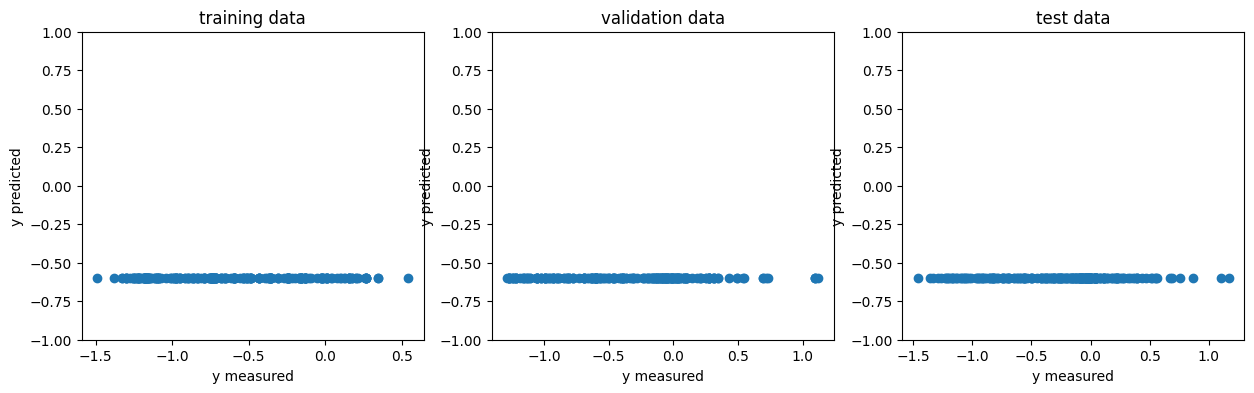

In [63]:
plot_prediction_correlations(y_single_z10_train, y_single_z10_val, y_single_z10_test)

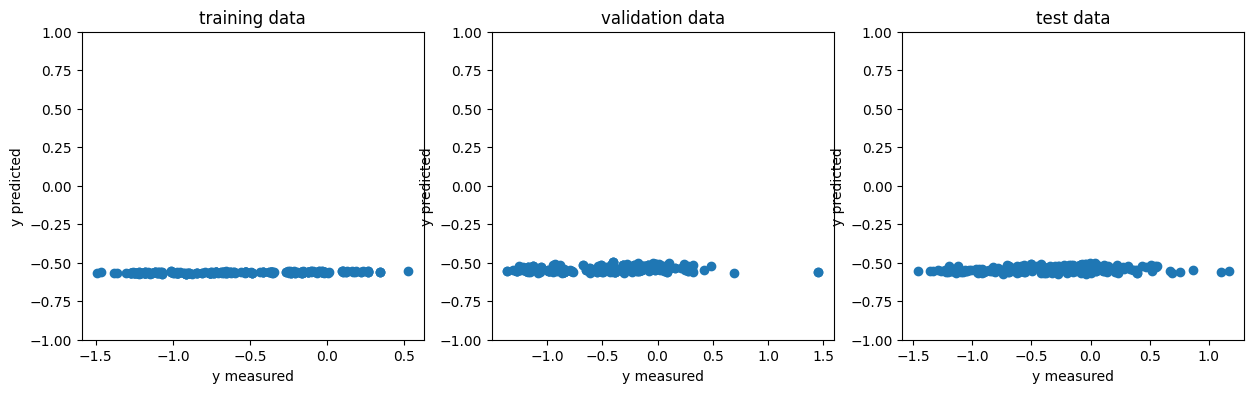

In [65]:
plot_prediction_correlations(y_single_200_train, y_single_200_val, y_single_200_test)

Unfortunately the model predictiuons look extremely bad. All input is simply mapped to a flat line. 
This is surprizing, as the model showed promising results in the literature, and points to problems in the code or the model setup. 

It is possible that gradients in the type of model are sensitive to learning rate and initializations.

The ML flow logger allows inspection of the training curves of the metrics in the user interface (mlflow ui) 

The initial training effect looks promising, but after a few epochs there is no more training effect and the model starts to overfit. 

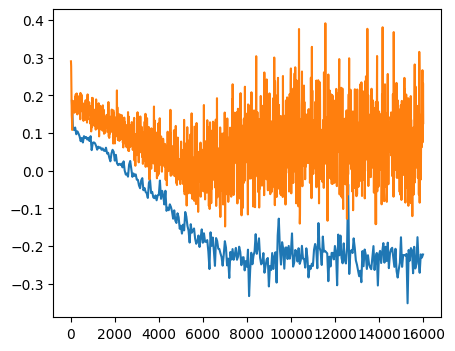

In [91]:
metrics1 = pd.read_csv('Data/Results/metrics_single_z1.csv')
metrics2 = pd.read_csv('Data/Results/metrics_single_z10_200a.csv')

metrics1_train= metrics1[metrics1.key=='train/loss']
metrics1_val= metrics1[metrics1.key=='val/loss']
metrics2_val= metrics2[metrics2.key=='val/loss']
metrics2_train= metrics2[metrics2.key=='train/loss']

metrics1.keys = metrics1[float()]

fig = plt.figure(figsize=(5,4) )
ax =  fig.subplots(nrows=1, ncols=1)

ax.plot(metrics1_train.step, metrics1_train.value)
ax.plot(metrics1_val.step, metrics1_val.value)

array([[ 3.14191729e-02, -1.16990954e-02,  1.20114014e-02, ...,
         4.12742421e-02,  9.99972820e-02, -3.17482650e-03],
       [ 3.05600390e-02, -7.08176941e-03,  1.14538372e-02, ...,
         4.05485816e-02,  9.97547656e-02, -1.89687312e-03],
       [ 3.09523493e-02, -8.38186592e-03,  1.32183954e-02, ...,
         3.75038385e-02,  1.01956218e-01, -8.95671546e-04],
       ...,
       [ 3.00812200e-02, -8.47551227e-03,  1.57268494e-02, ...,
         4.54432257e-02,  1.00307181e-01, -2.30711699e-03],
       [ 2.97393277e-02, -8.35426152e-03,  1.80333555e-02, ...,
         4.41671796e-02,  1.00490555e-01, -1.99874490e-03],
       [ 3.05245072e-02, -8.23940337e-03,  1.70073956e-02, ...,
         4.52034175e-02,  1.01271018e-01,  4.30867076e-05]], dtype=float32)

Next we take a look at the embeddings, produced by the Variational autoencoders.
The embedding shows a clear structuring of the latent space ito different clusters, both when fit with the TSME dimensionality reduction but also in the plain embedding space. Which suggests that these models, even in this simple form can learn an informative representation of the protein sequence and properties. The next step towards making predictions with such a model is to create distributions of conditioned sampling based on the variant and wild type and calculate their relative odds. 

Text(0.5, 1.0, 'vae projections')

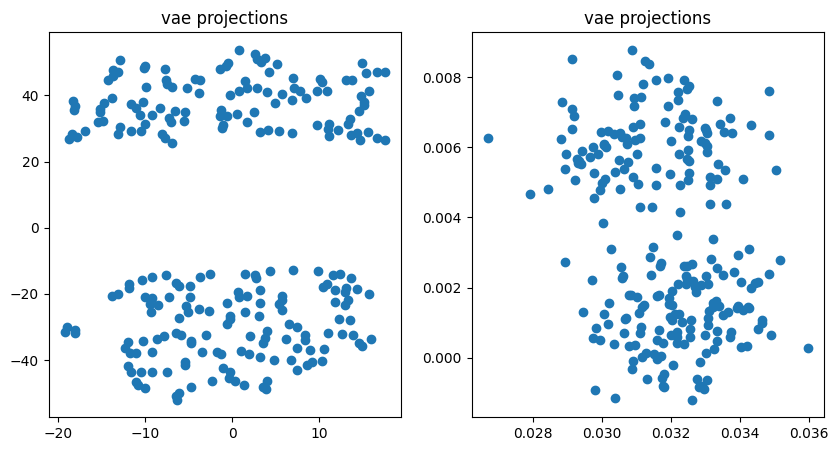

In [108]:
from sklearn.manifold import TSNE

tsne_embed = TSNE(n_components=2, learning_rate='auto', perplexity=10, random_state=0)
protein_vecs10_tsne = tsne_embed.fit_transform(np.array(z_vecs_10))
protein_vecs50_tsne = tsne_embed.fit_transform(z_vecs_50)

fig =plt.figure(figsize=(10,5) )
ax = fig.subplots(nrows=1, ncols=2)

ax[0].scatter(protein_vecs10_tsne[:,0], protein_vecs10_tsne[:,1])
ax[0].set_title('vae projections')

ax[1].scatter(z_vecs_10[:,0], z_vecs_10[:,3])
ax[1].set_title('vae projections')



### Finally though there are no predictions from the language embedding model, the loss curves suggest that it suffer from the same - to be determined- problem as the rest of the supervised models. Therefore, as a first step to evaluating the value of these embeddings by themselves, we look at a projection of the embedding dimensions

In [109]:
p_org = h5py.File('/home/andrea/Code/automl_model/protT5/output/protein_embeddings_0 .h5','r')
p_new = h5py.File('/home/andrea/Code/automl_model/protT5/output/protein_embeddings1.h5', 'r')
p_wt =h5py.File('/home/andrea/Code/automl_model/protT5/output/wt_prot_embeddings.h5', 'r')
wt_keys = list(p_wt.keys())
k_org = list(p_org.keys())
new_keys = list(p_new.keys())


In [110]:
wt_arrays =[]
for k in wt_keys:
    wt_arrays.append(np.array(p_wt[k]))
wt_arrays = np.array(wt_arrays)

prot_ids = []
emb_arrays = []

for k in k_org:
    prot_ids.append(k)
    emb_arrays.append(np.array(p_org[k]))
    
for k in new_keys:
    prot_ids.append(k)
    emb_arrays.append(np.array(p_new[k]))

emb_arrays = np.array(emb_arrays)

In [111]:
p_org.close()
p_new.close()
p_wt.close()

Text(0.5, 1.0, 'wt projections')

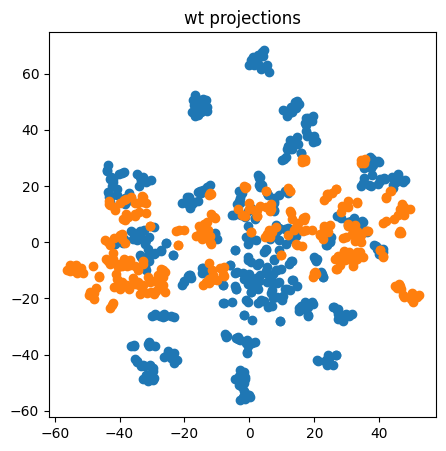

In [115]:
tsne_pretr = TSNE(n_components=2, learning_rate='auto', perplexity=10, random_state=0)
protein_wt_tsne = tsne_pretr.fit_transform(wt_arrays)

protein_subset_tsne = tsne_pretr.fit_transform(emb_arrays[:500])


fig = plt.figure(figsize=(5,5) )
ax = fig.subplots(nrows=1, ncols=1)

ax.scatter(protein_subset_tsne[:,0],protein_subset_tsne[:,1])
ax.scatter(protein_wt_tsne[:,0], protein_wt_tsne[:,1])
ax.set_title('wt projections')

This projection again shows a clear separation, suggesting that a simple top level prediction model can likely learn to predict functional scores, such as protein stability based on the position in the embedding space